In [2]:
import sys, os


import pickle
import networkx as nx
from geopy.distance import great_circle
import geohash
import geopandas as gpd
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import contextily as cx
from shapely.geometry import Polygon,Point
from shapely import wkt,ops
import colorsys
from sklearn.preprocessing import StandardScaler
from scipy import spatial
import random
from matplotlib.colors import LogNorm
from scipy import stats

In [3]:
from io import BytesIO
import palettable

In [4]:

plt.rcParams['font.sans-serif'] = ['Arial'] + ['DejaVu Sans',
                              'Bitstream Vera Sans',
                              'Computer Modern Sans Serif',
                              'Lucida Grande',
                              'Verdana',
                              'Geneva',
                              'Lucid',
                              'Arial',
                              'Helvetica',
                              'Avant Garde',
                              'sans-serif']

In [5]:
ca_avg_integral, ca_entire_integral,ca_valid_integral = {}, {},{}
for ca in ['mx', 'in', 'co']:
    urbanicity_df = pd.read_csv(f'{ca}_urbanicity_v2.csv')
    cids = urbanicity_df[urbanicity_df.area_type=='urban'].groupby('cluster_id').count().sort_values('cluster_id', ascending=False)[:5].index.tolist()
    ca_avg_integral[ca] = pd.read_csv(f'processing/{ca}_vector_field_integral_avg.csv')
    with open(f'processing/{ca}_vector_field_cid_integral.pkl', 'rb') as handle:
        ca_entire_integral[ca] = pickle.load(handle)

/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README


In [5]:
ca_avg_integral[ca]

,cid,integral,time_type
0,13,29.518254,night_wd
1,13,26.199405,night_wd
2,13,48.557057,day_wd
3,13,52.093446,day_wd
4,13,33.011053,day_wd
...,...,...,...
75,2,80.999995,day_we
76,2,98.996811,day_we
77,2,80.999997,day_we
78,2,76.500305,day_we


In [6]:
cid_name = {'2_co':'Cartagena', '10_co':'Barranquilla', '17_co':'Cali', '32_co':'Medellin', '13_co':'Bogota',
 '7_mx':'Guadalajara', '37_mx':'Monterrey', '14_mx':'Puebla', '42_mx':'Santiago de Querétaro', '1_mx':'Mexico City',
 '14_in':'Kolkata', '99_in':'Hyderabad', '81_in':'Bengaluru', '32_in':"New Delhi", '13_in':'Mumbai'
}

In [7]:

avg_int_df,valid_int_df = [],[]
for i,ca in enumerate(ca_entire_integral.keys()):
    for cid,integral in ca_entire_integral[ca].items():

        xs = range(len(integral))
        ys = integral
        avg_int_df += [[cid_name[str(cid)+'_'+ca]] + ys ]
        valid_int_df += [[cid_name[str(cid)+'_'+ca]] + ca_valid_integral[ca][cid]]
avg_int_df = pd.DataFrame(avg_int_df, columns=['cid'] + list(range(16))).set_index('cid')
valid_int_df = pd.DataFrame(valid_int_df, columns=['cid'] + list(range(16))).set_index('cid')
avg_int_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cid,,,,,,,,,,,,,,,,
Mexico City,38.656850,31.361047,38.869675,43.516281,41.815485,40.901155,38.800376,34.355741,37.800714,37.245040,38.189983,42.970700,45.648569,44.498845,46.941394,42.616310
Santiago de Querétaro,42.709442,48.364304,42.037458,53.620382,46.615423,47.076423,50.644361,42.819233,43.172900,46.626229,41.520564,52.828888,48.922222,58.778491,46.281425,47.552273
Puebla,30.986827,32.473701,39.161099,38.012028,38.421200,35.743356,27.200366,30.477328,23.773813,22.326959,31.885900,42.465676,43.255700,44.286988,45.111446,37.655364
Monterrey,54.661107,44.864544,56.060778,66.499156,59.070667,46.013178,45.011704,37.584750,42.810665,47.861148,38.402856,61.074297,51.039402,49.433938,50.233415,52.037432
Guadalajara,57.734762,50.836130,65.680999,62.929214,56.036788,59.930106,47.308735,35.825082,51.015852,30.587029,47.562147,67.965276,48.467516,46.408535,60.633255,46.179065
New Delhi,54.726616,46.624828,44.710908,67.795046,56.476176,55.299584,50.885646,38.976762,51.489497,53.239469,47.074371,56.472578,65.445251,62.063909,65.736610,34.272546
Mumbai,56.479468,69.284865,57.811716,72.000809,73.366037,67.372613,54.003358,49.113926,59.473451,66.281388,61.366835,69.816171,65.457664,63.548038,65.455196,48.295047
Bengaluru,64.341565,62.559867,72.120358,65.772169,64.616316,61.442797,63.462312,39.228227,57.121946,66.646061,59.434211,62.598486,70.097634,57.404974,47.019955,44.431741
Hyderabad,58.027570,44.458795,81.819958,65.456713,57.647678,47.232627,43.885267,46.126719,52.044187,46.318153,65.478859,73.636731,73.266185,45.378644,29.753951,51.701489


In [12]:
str_time_dict = {'00:00:00 - 03:00:00': 0,
 '03:00:00 - 06:00:00': 1,
 '06:00:00 - 09:00:00': 2,
 '09:00:00 - 12:00:00': 3,
 '12:00:00 - 15:00:00': 4,
 '15:00:00 - 18:00:00': 5,
 '18:00:00 - 21:00:00': 6,
 '21:00:00 - 24:00:00': 7}
time_str_dict = {v:k for k,v in str_time_dict.items()}
time_str_dict

{0: '00:00:00 - 03:00:00',
 1: '03:00:00 - 06:00:00',
 2: '06:00:00 - 09:00:00',
 3: '09:00:00 - 12:00:00',
 4: '12:00:00 - 15:00:00',
 5: '15:00:00 - 18:00:00',
 6: '18:00:00 - 21:00:00',
 7: '21:00:00 - 24:00:00'}

In [40]:
df_valid_norm = 180 - valid_int_df
df_valid_norm = (df_valid_norm-0)/180
df_valid_norm += 1e-8
df_valid_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cid,,,,,,,,,,,,,,,,
Mexico City,0.605381,0.625228,0.620625,0.616695,0.615317,0.616982,0.626784,0.648924,0.628073,0.599778,0.633248,0.600560,0.597180,0.598208,0.585867,0.603812
Santiago de Querétaro,0.670599,0.646516,0.715742,0.643241,0.706150,0.689084,0.661401,0.705505,0.697307,0.646675,0.698593,0.649395,0.650763,0.630107,0.675838,0.683926
Puebla,0.627773,0.615439,0.628496,0.625193,0.627212,0.633803,0.693915,0.655870,0.647517,0.620833,0.637586,0.585931,0.610717,0.591049,0.587119,0.618587
Monterrey,0.653373,0.693353,0.673829,0.609126,0.634723,0.671984,0.707546,0.721212,0.689547,0.685946,0.706231,0.590426,0.640085,0.645174,0.678201,0.680426
Guadalajara,0.685370,0.735384,0.650077,0.643795,0.694416,0.706312,0.766575,0.837043,0.704928,0.758173,0.691010,0.608450,0.644111,0.669910,0.683102,0.721828
New Delhi,0.659146,0.698806,0.702989,0.602587,0.634906,0.648933,0.716651,0.771412,0.650138,0.682965,0.724185,0.649524,0.613646,0.630306,0.675552,0.764095
Mumbai,0.694516,0.625799,0.663660,0.603067,0.654180,0.652939,0.749224,0.799216,0.703533,0.643784,0.644578,0.636098,0.676207,0.664119,0.687943,0.774293
Bengaluru,0.708594,0.705829,0.660427,0.663403,0.675468,0.755010,0.743856,0.842726,0.752877,0.700515,0.727201,0.683444,0.680361,0.706117,0.792079,0.824699
Hyderabad,0.738861,0.783058,0.590667,0.652827,0.755032,0.784774,0.822894,0.810436,0.780098,0.787097,0.689736,0.663349,0.634520,0.800368,0.899596,0.802623


Best number of clusters (Silhouette Score): 4
Best number of clusters (Calinski-Harabasz Index): 4
/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/cluster_validation_efficiency_transit_alignment.pdf' to bucket 'niyer-processed'.


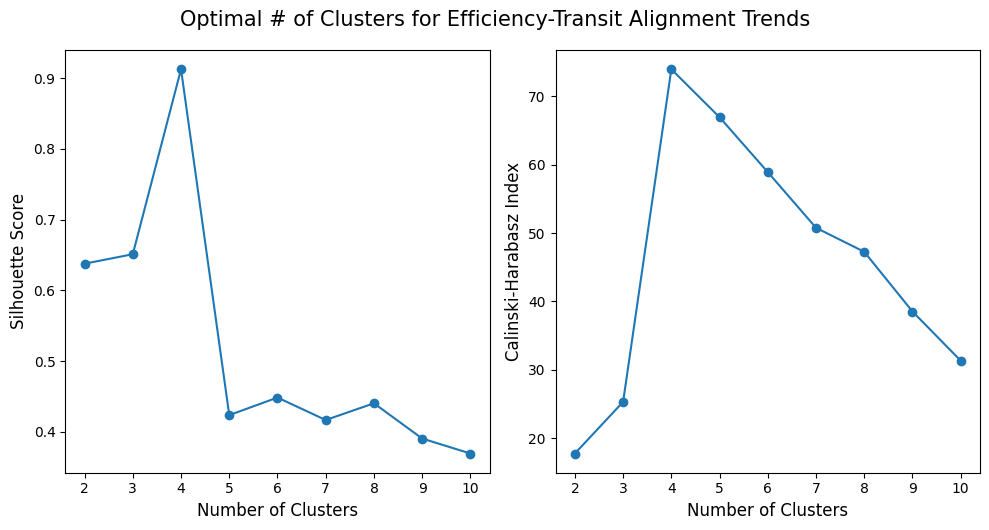

In [128]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import numpy as np
import matplotlib.pyplot as plt

X = np.array(df_valid_norm)  

sil_scores = []
calinski_scores = []
range_n_clusters = range(2, 11)  # Check from 2 to 10 clusters (adjust as needed)

for n_clusters in range_n_clusters:
    # Perform spectral clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
    labels = spectral.fit_predict(X)

    silhouette_avg = silhouette_score(X, labels, metric="cosine")
    sil_scores.append(silhouette_avg)

    calinski_avg = calinski_harabasz_score(X, labels)
    calinski_scores.append(calinski_avg)

fig,(ax1,ax2) =plt.subplots(1,2, figsize=(10,5))
ax1.plot(range_n_clusters, sil_scores, marker='o')
ax1.set_xlabel("Number of Clusters", fontsize=12)
ax1.set_ylabel("Silhouette Score", fontsize=12)

ax2.plot(range_n_clusters, calinski_scores, marker='o')
ax2.set_xlabel("Number of Clusters", fontsize=12)
ax2.set_ylabel("Calinski-Harabasz Index", fontsize=12)

plt.tight_layout()
fig.suptitle('Optimal # of Clusters for Efficiency-Transit Alignment Trends', fontsize=15,y=1.05)
# plt.show()

# Select best n_clusters based on maximum silhouette score or Calinski-Harabasz
best_n_clusters_sil = range_n_clusters[np.argmax(sil_scores)]
best_n_clusters_calinski = range_n_clusters[np.argmax(calinski_scores)]

print(f"Best number of clusters (Silhouette Score): {best_n_clusters_sil}")
print(f"Best number of clusters (Calinski-Harabasz Index): {best_n_clusters_calinski}")




In [119]:
X = np.array(df_valid_norm)

# Compute similarity (cosine similarity here)
cosine_sim = cosine_similarity(X)

# Spectral clustering
spectral = SpectralClustering(n_clusters=4, affinity='rbf')
labels = spectral.fit_predict(X)  # 1 - similarity gives distance
df_valid_norm['Cluster'] = labels
df_valid_norm



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Cluster
cid,,,,,,,,,,,,,,,,,
Mexico City,0.605381,0.625228,0.620625,0.616695,0.615317,0.616982,0.626784,0.648924,0.628073,0.599778,0.633248,0.600560,0.597180,0.598208,0.585867,0.603812,2
Santiago de Querétaro,0.670599,0.646516,0.715742,0.643241,0.706150,0.689084,0.661401,0.705505,0.697307,0.646675,0.698593,0.649395,0.650763,0.630107,0.675838,0.683926,3
Puebla,0.627773,0.615439,0.628496,0.625193,0.627212,0.633803,0.693915,0.655870,0.647517,0.620833,0.637586,0.585931,0.610717,0.591049,0.587119,0.618587,3
Monterrey,0.653373,0.693353,0.673829,0.609126,0.634723,0.671984,0.707546,0.721212,0.689547,0.685946,0.706231,0.590426,0.640085,0.645174,0.678201,0.680426,1
Guadalajara,0.685370,0.735384,0.650077,0.643795,0.694416,0.706312,0.766575,0.837043,0.704928,0.758173,0.691010,0.608450,0.644111,0.669910,0.683102,0.721828,1
New Delhi,0.659146,0.698806,0.702989,0.602587,0.634906,0.648933,0.716651,0.771412,0.650138,0.682965,0.724185,0.649524,0.613646,0.630306,0.675552,0.764095,1
Mumbai,0.694516,0.625799,0.663660,0.603067,0.654180,0.652939,0.749224,0.799216,0.703533,0.643784,0.644578,0.636098,0.676207,0.664119,0.687943,0.774293,2
Bengaluru,0.708594,0.705829,0.660427,0.663403,0.675468,0.755010,0.743856,0.842726,0.752877,0.700515,0.727201,0.683444,0.680361,0.706117,0.792079,0.824699,1
Hyderabad,0.738861,0.783058,0.590667,0.652827,0.755032,0.784774,0.822894,0.810436,0.780098,0.787097,0.689736,0.663349,0.634520,0.800368,0.899596,0.802623,1


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/precise_vf_integral_comp_15_cities_validation.pdf' to bucket 'niyer-processed'.


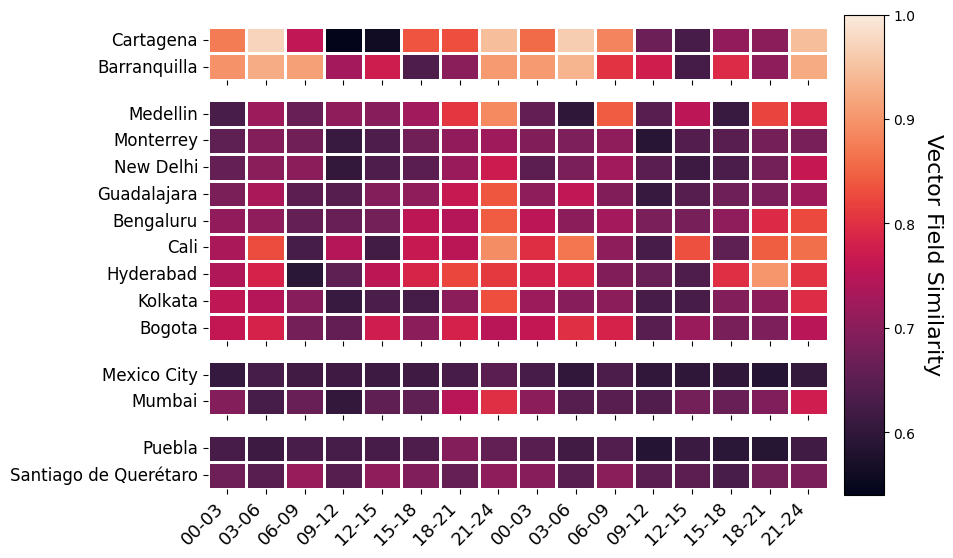

In [121]:
import matplotlib as mpl

clusters = df_valid_norm.groupby('Cluster').count().index
fig,axes = plt.subplots(len(clusters),1, figsize=(8,6), height_ratios=df_valid_norm.groupby('Cluster').count()[0].tolist())
vmin = df_valid_norm.drop('Cluster',axis=1).min().min()  # Minimum value for colorbar
vmax = 1 #df_valid_norm.drop('Cluster',axis=1).max().max()  # Maximum value for colorbar


for i in clusters:
    ax=axes[i]
    sns.heatmap(df_valid_norm[df_valid_norm.Cluster==i].drop('Cluster',axis=1).sort_values(0),ax =axes[i], cbar=False, linewidths=1, linecolor='white',
               vmin=vmin, vmax=vmax)
    if i < len(clusters)-1:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([time_str_dict[i%8][:2] + '-' + time_str_dict[i%8][11:13] for i in range(16)], fontsize=13, rotation=45, ha='right')
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])  # [left, bottom, width, height]
sm = mpl.cm.ScalarMappable(cmap="rocket", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

# Add the colorbar to the defined colorbar axis
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Vector Field Similarity', rotation=270, fontsize=16, labelpad=20)  # Optional: Add a label to the colorbar

